# Images as Sequences

Although typically 2D, we can treat images as in a similar way to text. 

We can treat the RGB values (e.g. `243-78-23`) as tokens and flatten the image into 1 long list. In this way, we can model and generate images using the same techniques we might use for generating text, however, instead of the tokens being words or characters, they are pixel colour values!

In this notebook, you can generate new images from a directory of images using either **Markov Models** or **LSTMS**. 

Your choice of dataset, amount of history you look at when predicting the next values and other model parameters will effect your outcomes

### MAKE SURE YOU ARE RUNNING A GPU


# Markov Model 

The code below uses William Indexes Markov Model code to generate images based on a dataset. 


In [1]:
!git clone https://github.com/william-index/markov-fun

Cloning into 'markov-fun'...
remote: Enumerating objects: 234, done.
remote: Total 234 (delta 0), reused 0 (delta 0), pack-reused 234
Receiving objects: 100% (234/234), 3.02 MiB | 3.72 MiB/s, done.
Resolving deltas: 100% (62/62), done.


In [3]:
%cd /content/markov-fun/

/content/markov-fun


In [8]:
import argparse, os, pickle
from PIL import Image
from Trainer import DataTrainer, ImageSequencer
from Stepper import Stepper


def generate_markov():
  trainer = DataTrainer()
  stepper = Stepper()
  img_sequencer = ImageSequencer()

  should_pickle = True
  pickle_file_name = "{width}-{height}-{norder}.pickle".format(width=im_width, height=im_height, norder=norder)
  pickled_data = {}
  preexisting_pickle = False

  #  checks for and loads pickle
  if should_pickle:
      print('checking for pickle..')

      has_pickle = os.path.isfile(directory + pickle_file_name)
      if has_pickle:
          print('Loading Pickled Data...')
          with open(directory + pickle_file_name, 'rb') as pickle_file:
              pickled_data = pickle.load(pickle_file)

  if pickled_data:
      print('Pickled data set')
      trained_data = pickled_data
      preexisting_pickle = True
  else:
      print('Training based on image set...')
      image_set = []
      for fn in os.listdir(directory):
          if fn[0] != '.' and fn[-7:] !=".pickle":
              image_set.append(directory + fn)

      concat_text = ""
      for image in image_set:
          image = Image.open(image)
          image_as_text = img_sequencer.sequence_image_to_text(image)
          concat_text = concat_text + ' ' + image_as_text

      concat_text.strip()

      trained_data = trainer.train_text_data(
              raw_text = concat_text,
              order = norder,
              )

  # saves pickeled data
  if should_pickle and preexisting_pickle == False:
      print('Pickling data for later use...')
      with open(directory + pickle_file_name, 'wb+') as pickle_file:
          pickle.dump(trained_data, pickle_file)
          pickle_file.close()

  print('Stepping Image Sequence...')
  gen_seq = stepper.new_set_length_sequence(
          model = trained_data,
          steps = im_width * im_height
          )

  print('Generating Image...')
  image = img_sequencer.convert_text_to_image(gen_seq, im_width, im_height)
  image.save("data/processed/images/sample.png")

# Upload your images

Probably the easiest way to do this is to mount your Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Parameters

There are 3 main parameters to play with when generating images 

1. The dataset. Point the model to a directory containing image files (e.g. one you have uploaded to your mounted Google Drive)

2. Size of image to be generated 

3. Order of the Markov chain. This determines how many previous pixels we look at when guessing the next one



In [5]:
directory = "data/training/curated/bauhaus/"
im_width, im_height = 128,128
norder = 250

# Generate!

In [12]:
generate_markov()

checking for pickle..
Loading Pickled Data...
Pickled data set
Stepping Image Sequence...
Generating Image...


# View Image

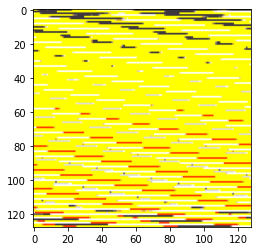

In [13]:
import matplotlib.pyplot as plt
im = Image.open("data/processed/images/sample.png")
plt.imshow(im)
plt.show()

# LSTMS

Now we're going to compare the output of the Markov Model to an LSTM. This code is editted from the [Keras Char level LSTM example](https://keras.io/examples/generative/lstm_character_level_text_generation/)



In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import random
import io

# Make dataset

Again we can pick

1. Dataset of images

2. Amount of history to look back on (`norder`)

In [21]:
directory = "data/training/curated/bauhaus/"
im_width, im_height = 128,128
norder = 250

img_sequencer = ImageSequencer()
image_set = []
for fn in os.listdir(directory):
          if fn[0] != '.' and fn[-7:] !=".pickle":
              image_set.append(directory + fn)
concat_text = ""
for image in image_set:
    image = Image.open(image)
    image_as_text = img_sequencer.sequence_image_to_text(image)
    concat_text = concat_text + ' ' + image_as_text

concat_text.strip()

text = concat_text.split()
chars = sorted(list(set(text)))
print("Total chars:", len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# cut the text in semi-redundant sequences of maxlen characters
maxlen = 250
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i : i + maxlen])
    next_chars.append(text[i + maxlen])
print("Number of sequences:", len(sentences))

x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

sequencing...
sequencing...
sequencing...
sequencing...
sequencing...
sequencing...
sequencing...
sequencing...
sequencing...
sequencing...
sequencing...
Total chars: 15
Number of sequences: 146584


# Compile Model

In [22]:
model = keras.Sequential(
    [
        keras.Input(shape=(maxlen, len(chars))),
        layers.LSTM(128),
        layers.Dense(len(chars), activation="softmax"),
    ]
)
optimizer = keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(loss="categorical_crossentropy", optimizer=optimizer)


# Train Model

In [23]:
epochs = 20
batch_size = 512
for epoch in range(epochs):
    model.fit(x, y, batch_size=batch_size, epochs=1)

287/287 [==============================] - 12s 40ms/step - loss: 0.3652


In [24]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def generate(diversity = 1.0):
    # helper function to generate new pixel sequence
    print()
    print("Generating text after epoch: %d" % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    print("...Diversity:", diversity)

    generated = ""
    sentence = text[start_index : start_index + maxlen]
    print('...Generating with seed: "' + str(sentence) + '"')

    for i in range(im_width * im_height):
        x_pred = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(sentence):
            x_pred[0, t, char_indices[char]] = 1.0
        preds = model.predict(x_pred, verbose=0)[0]
        next_index = sample(preds, diversity)
        next_char = indices_char[next_index]
        sentence[:-1]=sentence[1:]
        sentence[-1]=next_char
        generated = generated + " "  + next_char

    print("...Generated: ", generated)
    print()
    image = img_sequencer.convert_text_to_image(generated, im_width, im_height)
    image.save("data/processed/images/sample.png")

#Generate a new image

Warning, making bigger images (e.g. 128 x 128) make take a while (~ 5mins)

Pick a `diversity` values between 0.2 and 1.5, this determines how true to the original dataset the generation is. High diversity = more random.

In [25]:
im_width = 32
im_height = 32
diversity = 1.0
generate(diversity)


Generating text after epoch: 19
...Diversity: 1.0
...Generating with seed: "['247-243-222', '255-255-255', '255-255-255', '255-255-255', '255-255-255', '255-255-255', '255-255-255', '255-255-255', '255-255-255', '255-255-255', '255-255-255', '255-255-255', '255-255-255', '255-255-255', '255-255-255', '255-255-255', '255-255-255', '255-255-255', '255-255-255', '255-59-0', '3-1-3', '3-1-3', '3-1-3', '3-1-3', '3-1-3', '3-1-3', '3-1-3', '3-1-3', '3-1-3', '3-1-3', '3-1-3', '3-1-3', '3-1-3', '3-1-3', '3-1-3', '3-1-3', '3-1-3', '3-1-3', '255-255-255', '255-255-255', '255-255-255', '255-255-255', '255-255-255', '255-255-255', '255-255-255', '255-255-255', '255-255-255', '255-255-255', '255-255-255', '255-255-255', '255-255-255', '255-255-255', '255-255-255', '255-255-255', '255-255-255', '255-255-255', '255-255-255', '255-255-255', '255-255-255', '255-255-255', '255-255-255', '255-255-0', '3-1-3', '3-1-3', '3-1-3', '3-1-3', '3-1-3', '3-1-3', '3-1-3', '247-243-222', '255-255-255', '255-255-255

# View image

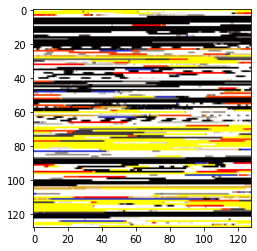

In [65]:
import matplotlib.pyplot as plt
im = Image.open("data/processed/images/sample.png")
plt.imshow(im)
plt.show()